# 1. Setup Notebook

## 1.1. Import Libaries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

## 1.2. Import Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 1.3. Setup Function / Modules

In [3]:
def extract_string(column_input):
    if pd.isna(column_input):
        return None
    matches = re.findall(r'\d+\.\d+|\d+', column_input)
    if matches:
        return float(matches[0])
    else:
        return None
    
def remove_outliers_iqr(df, columns_to_check=None, factor=1.5):
    if columns_to_check is None:
        columns_to_check = df.columns

    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df[columns_to_check] < (Q1 - factor * IQR)) | (df[columns_to_check] > (Q3 + factor * IQR))).any(axis=1)

    df_filtered = df[mask]

    return df_filtered

# 2. Data Pre-Processing

## 2.1. View Data

In [4]:
train.head(5)

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datetime      341880 non-null  int64 
 1   datetime_iso  341880 non-null  object
 2   time-zone     341880 non-null  int64 
 3   temp          341880 non-null  object
 4   visibility    51112 non-null   object
 5   d_point       341880 non-null  object
 6   feels         341880 non-null  object
 7   min_temp      341880 non-null  object
 8   max_temp      341880 non-null  object
 9   prssr         341880 non-null  object
 10  sea_level     192964 non-null  object
 11  grnd_level    192919 non-null  object
 12  hum           341880 non-null  object
 13  wind_spd      341880 non-null  object
 14  wind_deg      341880 non-null  object
 15  rain_1h       341880 non-null  object
 16  rain_3h       192329 non-null  object
 17  snow_1h       192696 non-null  object
 18  snow_3h       192699 non

## 2.2. Extract String

In [6]:
columns_to_extract = ['temp', 'min_temp', 'max_temp', 
                      'prssr', 'hum', 'wind_spd', 
                      'rain_1h', 'rain_3h', 'snow_1h', 
                      'snow_3h', 'clouds', 'd_point', 
                      'feels', 'wind_deg']

for column in columns_to_extract:
    train[column] = train[column].apply(lambda x: extract_string(x))


In [7]:
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,unidentified,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


## 2.3. Convert `datetime_iso` To Datetime

In [8]:
train['datetime_iso'] = pd.to_datetime(train['datetime_iso'], format='%Y-%m-%d %H:%M:%S%z')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   datetime      341880 non-null  int64              
 1   datetime_iso  341880 non-null  datetime64[ns, UTC]
 2   time-zone     341880 non-null  int64              
 3   temp          341880 non-null  float64            
 4   visibility    51112 non-null   object             
 5   d_point       341880 non-null  float64            
 6   feels         341880 non-null  float64            
 7   min_temp      341880 non-null  float64            
 8   max_temp      341880 non-null  float64            
 9   prssr         341880 non-null  float64            
 10  sea_level     192964 non-null  object             
 11  grnd_level    192919 non-null  object             
 12  hum           341880 non-null  float64            
 13  wind_spd      341880 non-null  float64      

In [9]:
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,unidentified,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


## 2.4. Drop Unnecessary Column

In [10]:
train.apply(pd.isnull).sum()/train.shape[0]

datetime        0.000000
datetime_iso    0.000000
time-zone       0.000000
temp            0.000000
visibility      0.850497
d_point         0.000000
feels           0.000000
min_temp        0.000000
max_temp        0.000000
prssr           0.000000
sea_level       0.435580
grnd_level      0.435711
hum             0.000000
wind_spd        0.000000
wind_deg        0.000000
rain_1h         0.077799
rain_3h         0.545963
snow_1h         0.513040
snow_3h         0.523189
clouds          0.000000
dtype: float64

In [11]:
train = train.drop(['datetime', 'time-zone', 'visibility',
            'sea_level','grnd_level'], axis=1)
train.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


In [12]:
train_df = train.set_index('datetime_iso')
train_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
datetime_iso,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


In [13]:
train_df.isna().sum()

temp             0
d_point          0
feels            0
min_temp         0
max_temp         0
prssr            0
hum              0
wind_spd         0
wind_deg         0
rain_1h      26598
rain_3h     186654
snow_1h     175398
snow_3h     178868
clouds           0
dtype: int64

In [14]:
train_df['rain_1h'] = train_df['rain_1h'].fillna(train_df['rain_1h'].mean())
train_df.isna().sum()

temp             0
d_point          0
feels            0
min_temp         0
max_temp         0
prssr            0
hum              0
wind_spd         0
wind_deg         0
rain_1h          0
rain_3h     186654
snow_1h     175398
snow_3h     178868
clouds           0
dtype: int64

<Axes: xlabel='datetime_iso'>

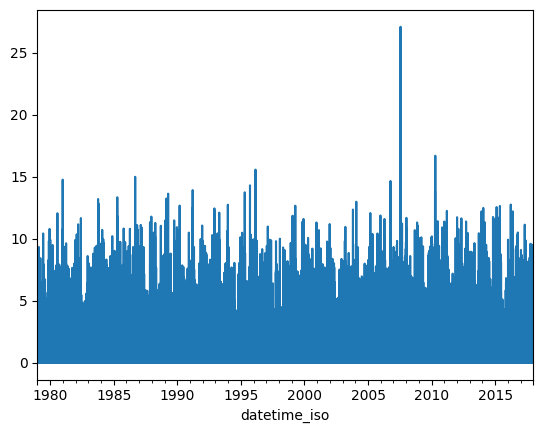

In [15]:
train_df['rain_1h'].plot()

In [16]:
train_df['delta_temp'] = train_df['temp'] - train_df['d_point']
train_df['relative_humadity'] = (1- (train_df['d_point'] / train_df['temp'])) * 100
# train_df['combined_weather_feature'] = train_df['temp'] * train_df['relative_humidity'] * train_df['clouds']

In [17]:
train_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds,delta_temp,relative_humadity
datetime_iso,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,0.0,NaN,NaN,100.0,0.86,3.474747
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,0.0,0.0,0.0,100.0,0.85,3.458096
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,NaN,NaN,NaN,99.0,2.54,9.548872
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,NaN,0.0,NaN,94.0,2.94,10.765287
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,NaN,NaN,0.0,100.0,2.36,8.609996


In [18]:
train2 = train_df.drop(['rain_3h','snow_1h','snow_3h'], axis = 1)

In [19]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341880 entries, 1979-01-01 00:00:00+00:00 to 2017-12-31 23:00:00+00:00
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   temp               341880 non-null  float64
 1   d_point            341880 non-null  float64
 2   feels              341880 non-null  float64
 3   min_temp           341880 non-null  float64
 4   max_temp           341880 non-null  float64
 5   prssr              341880 non-null  float64
 6   hum                341880 non-null  float64
 7   wind_spd           341880 non-null  float64
 8   wind_deg           341880 non-null  float64
 9   rain_1h            341880 non-null  float64
 10  clouds             341880 non-null  float64
 11  delta_temp         341880 non-null  float64
 12  relative_humadity  341880 non-null  float64
dtypes: float64(13)
memory usage: 36.5 MB


In [20]:
train2['combined_weather_feature'] = train2['temp'] * train2['relative_humadity'] * train2['clouds']


In [21]:
train2.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds,delta_temp,relative_humadity,combined_weather_feature
datetime_iso,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0,0.86,3.474747,8600.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0,0.85,3.458096,8500.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0,2.54,9.548872,25146.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0,2.94,10.765287,27636.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0,2.36,8.609996,23600.0


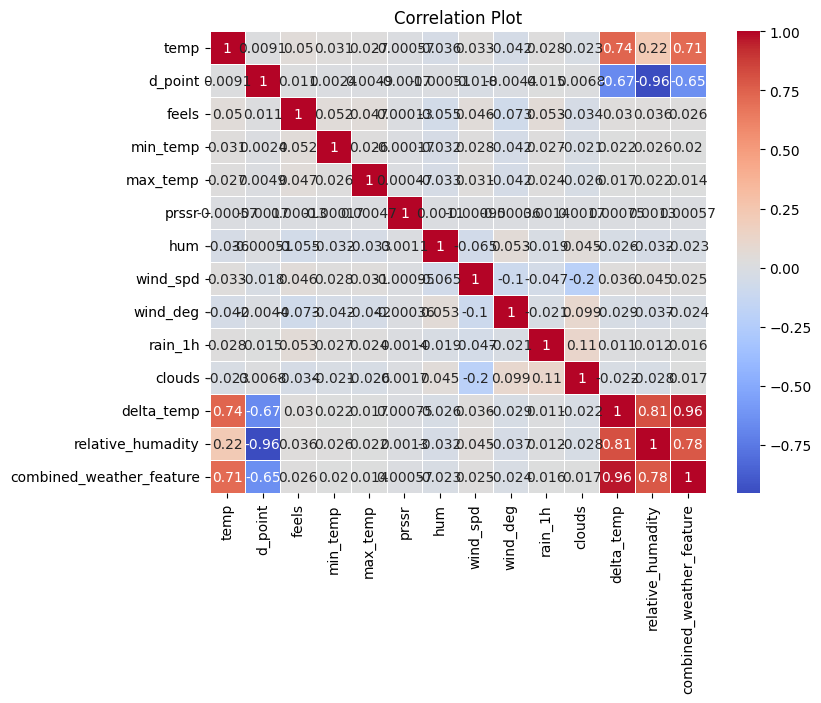

In [22]:
# Calculate the correlation matrix
correlation_matrix = train2.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [23]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [28]:
def test_stationarity(timeseries, subset_size=1000):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries[:subset_size], autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Stationary (Reject H0)")
    else:
        print("Non-Stationary (Fail to Reject H0)")

def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(timeseries, lags=30, ax=ax1)
    plot_pacf(timeseries, lags=30, ax=ax2)
    plt.show()

In [29]:
timeseries = train2['rain_1h']

In [30]:
test_stationarity(timeseries)

ADF Statistic: -17.688585483079724
p-value: 3.5808815145827626e-30
Critical Values: {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
Stationary (Reject H0)


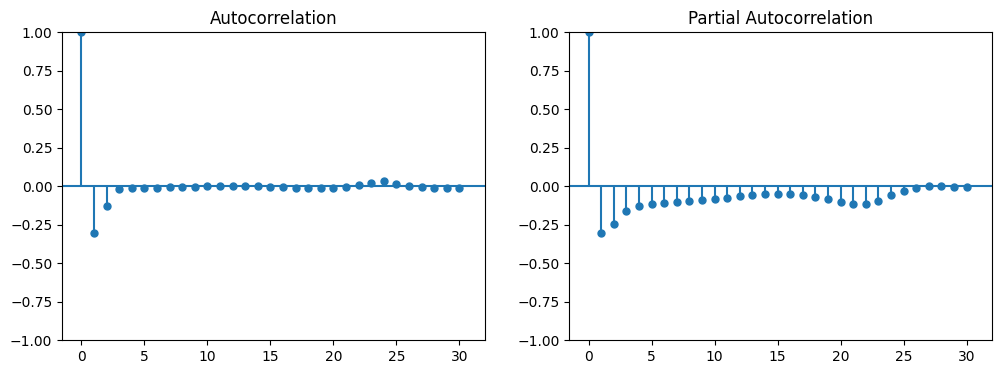

In [34]:
# If the time series is non-stationary, apply differencing to make it stationary
d = 1  # Order of differencing (you may need to adjust this)
timeseries_diff = timeseries.diff(periods=d).dropna()

# Plot ACF and PACF for the differenced time series to determine p and q values
plot_acf_pacf(timeseries_diff)

In [35]:
# Determine p, d, and q values based on the ACF and PACF plots
p = 1  # AutoRegressive (AR) order
d = 1  # Differencing order
q = 1  # Moving Average (MA) order
from statsmodels.tsa.arima.model import ARIMA
# Fit the ARIMA model
model = ARIMA(timeseries, order=(p, d, q))
results = model.fit()

# Print the model summary
print(results.summary())

c:\Users\MSI GL65\anaconda3\envs\gpu_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\MSI GL65\anaconda3\envs\gpu_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\MSI GL65\anaconda3\envs\gpu_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                rain_1h   No. Observations:               341880
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -425994.918
Date:                Tue, 05 Sep 2023   AIC                         851995.836
Time:                        18:07:10   BIC                         852028.063
Sample:                    01-01-1979   HQIC                        852005.106
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4170      0.001    684.595      0.000       0.416       0.418
ma.L1         -0.9963      0.000  -6742.363      0.000      -0.997      -0.996
sigma2         0.7076      0.000   1617.473      0.0

In [37]:
# Forecast future values
forecast_steps = 10  # Number of future time steps to forecast
forecast_obj = results.get_forecast(steps=forecast_steps)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()